In [1]:
import os
import sys
import pandas as pd
import datetime

import pathlib
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import importlib


from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model
from tensorflow import keras
from tensorflow.keras import callbacks  

# project specific
sys.path.append('../src')
from utils import data_handler
from utils import benchmark
from utils import visualisation
from utils.models import vanilla_autoencoder


import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()

import plotly.express as px
import plotly.subplots as sp
import plotly.graph_objs as go

pd.options.display.width = 1000





%load_ext tensorboard
!rm -rf ../workfiles/logs/

## Experiment 

In [2]:
suggested_genes_file_1 = '../../data/PD_genes_of_interest/signif_de_Disease_status_IDIOPATHIC_PD_01.tsv'
suggested_genes_file_2 = '../../data/PD_genes_of_interest/signif_de_PD_DIAGNOSIS_0.1.tsv'

not applying any filtering over phases
retaining all patient who have at least passed the Base Line Visit...
loading samples...
loaded 4445 samples
selecting genes based on median absolute deviation threshold:  5 ...
min MAD 0.0
max MAD 4194.0


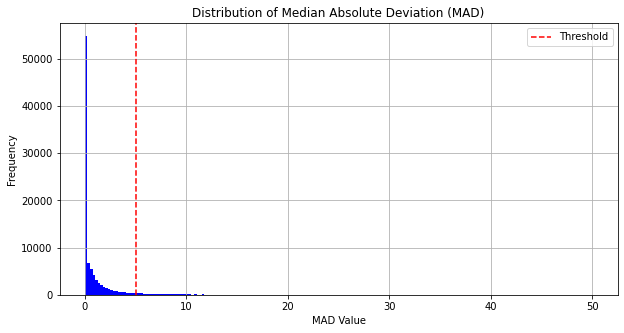

removing 89395 genes under the MAD threshold from the dataset
number of genes selected :  5914
log(1 + x) transformation...
scaling to [0, 1]...
number of seq in the dataset : 4445
keeping sample as is, no conversion to time series


In [3]:
# experiment 1
x_train, filenames, n_genes, gene_names = data_handler.generate_dataset_transcripts(
    feature_selection_threshold = 5, 
    gene_selection_file = None)

not applying any filtering over phases
retaining all patient who have at least passed the Base Line Visit...
loading samples...
loaded 4445 samples
selecting genes based on median absolute deviation threshold:  0 ...
min MAD 0.0
max MAD 2225.368


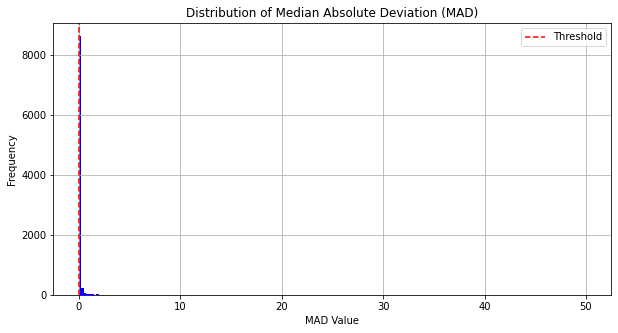

removing 6876 genes under the MAD threshold from the dataset
number of genes selected :  2185
log(1 + x) transformation...
scaling to [0, 1]...
number of seq in the dataset : 4445
keeping sample as is, no conversion to time series


In [3]:
# experiment 2
x_train, filenames, n_genes, gene_names = data_handler.generate_dataset_transcripts(
    feature_selection_threshold = 0, 
    gene_selection_file = suggested_genes_file_1)

not applying any filtering over phases
retaining all patient who have at least passed the Base Line Visit...
loading samples...
loaded 4445 samples
selecting genes based on median absolute deviation threshold:  0 ...
min MAD 0.0
max MAD 2225.368


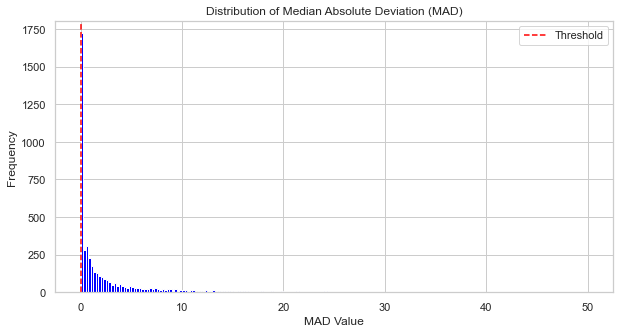

removing 1562 genes under the MAD threshold from the dataset
number of genes selected :  3283
log(1 + x) transformation...
scaling to [0, 1]...
number of seq in the dataset : 4445
keeping sample as is, no conversion to time series


In [41]:
# experiment 3
x_train, filenames, n_genes, gene_names = data_handler.generate_dataset_transcripts(
    feature_selection_threshold = 0, 
    gene_selection_file = suggested_genes_file_2)


## End of experiment selection

In [4]:
importlib.reload(vanilla_autoencoder) # to allow modification of the script without restarting the whole session

latent_dim = 32

t_shape = (n_genes)


autoencoder = vanilla_autoencoder.generate_model(t_shape, latent_dim)
autoencoder.compile(optimizer='adam', loss=tf.keras.losses.MeanSquaredError())

In [5]:
checkpoint_filepath = '../workfiles/simple_ae/checkpoint'
model_checkpoint_callback = callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='loss',
    mode='min',
    save_best_only=True)


reduce_lr = callbacks.ReduceLROnPlateau(monitor='loss', factor=0.2,
                              patience=20, min_lr=0.00001)

early_stopping_callback = callbacks.EarlyStopping(monitor='loss', patience=70)


log_dir = "../workfiles/logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

cb = [model_checkpoint_callback, reduce_lr, early_stopping_callback, tensorboard_callback]

In [ ]:
hist = autoencoder.fit(x_train, epochs=700, callbacks=cb) # around 16 hours for transcripts dataset 

In [7]:
autoencoder.load_weights(checkpoint_filepath)


benchmarking model : vanilla_autoencoder
number of parametters of the model: 5805632
shape of the dataset: (4445, 2185)
the dataset meets the min_max requirement
loss: 0.002430491
adding new performer to the history


,model_name,param_count,loss,obs_count,gene_number
0,FC_autoencoder,50460224,0.008361,4445,23989
1,FC_autoencoder,50460224,0.008114,4445,23989
2,vanilla_autoencoder,19887680,0.019203,4445,9061
3,vanilla_autoencoder,5805632,0.002761,4445,2185
4,vanilla_autoencoder,13442624,0.004807,4445,5914
5,vanilla_autoencoder,5805632,0.003180,4445,2185
6,vanilla_autoencoder,8054336,0.009517,4445,3283
0,vanilla_autoencoder,5805632,0.002430,4445,2185


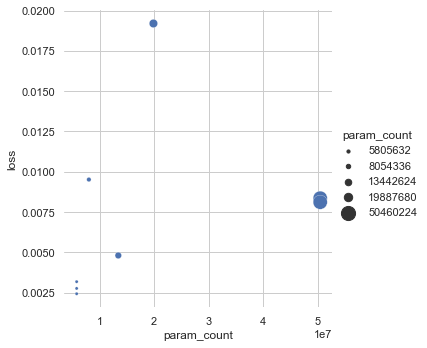

In [8]:
importlib.reload(benchmark) # to allow modification of the script without restarting the whole session
benchmark.benchmark(autoencoder, x_train)

[0.024878866970539093, 0.007792538497596979, 0.006837316323071718, 0.006697485223412514, 0.006560006178915501, 0.006430324167013168, 0.00635659322142601, 0.00632804399356246, 0.006355517078191042, 0.006562603171914816, 0.006527621764689684, 0.006386142689734697, 0.006223260425031185, 0.0061470563523471355, 0.006120351143181324, 0.006097438279539347, 0.0060313111171126366, 0.006000149995088577, 0.005972039885818958, 0.005908729508519173, 0.005846573505550623, 0.005812978371977806, 0.005786286201328039, 0.00574320275336504, 0.005704487208276987, 0.0056745619513094425, 0.005653677973896265, 0.005696062929928303, 0.005766021553426981, 0.0056704808957874775, 0.005697902757674456, 0.005647703073918819, 0.005595471244305372, 0.005567047279328108, 0.005573752801865339, 0.005571437533944845, 0.005568422377109528, 0.005516821518540382, 0.005532857030630112, 0.005559583660215139, 0.00556372944265604, 0.005563437007367611, 0.0055337208323180676, 0.0054854112677276134, 0.005528915673494339, 0.00551

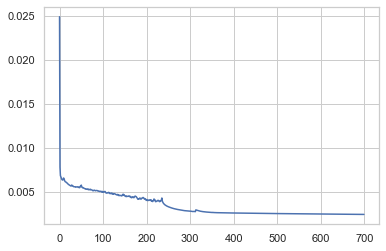

In [9]:
plt.plot(hist.history['loss'])
print(hist.history['loss'])

### some diagnosis

In [10]:
importlib.reload(visualisation) # to allow modification of the script without restarting the whole session
visualisation.plot_single_obs_processing(x_train, autoencoder)

In [11]:
compressed_dataframe = autoencoder.encoder.predict(x_train)

70/70 [==============================] - 0s 4ms/step


In [12]:
df = pd.DataFrame(compressed_dataframe)
df["name"] = filenames

139/139 [==============================] - 0s 3ms/step


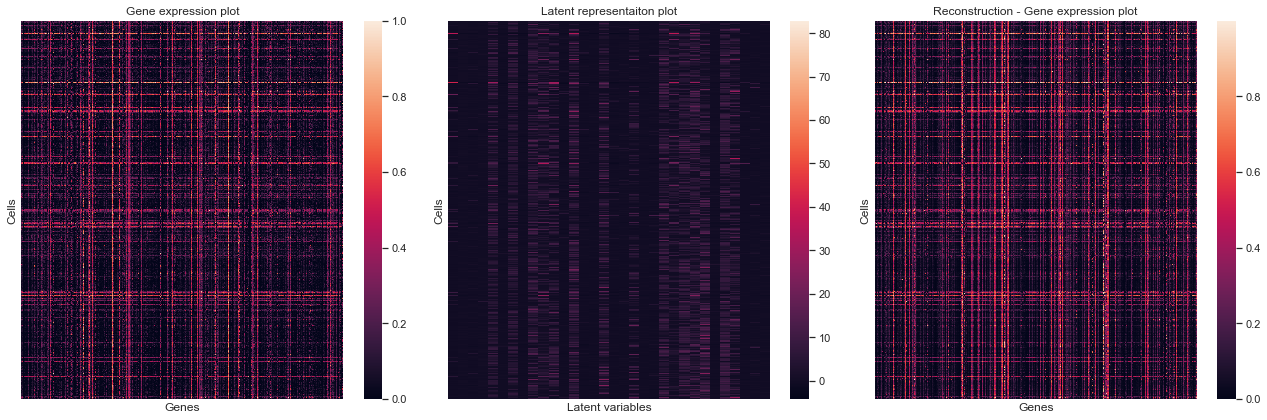

In [13]:
importlib.reload(visualisation) # to allow modification of the script without restarting the whole session
visualisation.plot_dataset_processing(x_train, autoencoder)

In [14]:
metadata_path = "../../METADATA_200123.xlsx"

meta_data = pd.read_excel(metadata_path, header = 1, usecols = range(1,10) )
patient_ids = [int(name.split(".")[1]) for name in filenames]

# Create a dictionary to map 'Patient Number' to 'Disease Status'
patient_disease_status = dict(zip(meta_data['Patient Number'], meta_data['Disease Status']))

label = [patient_disease_status.get(patient_id, None) for patient_id in patient_ids]
label = pd.Series(label)
num_classes = len(pd.Series(label).unique())

/opt/homebrew/anaconda3/envs/thesis/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/Users/aygalic/Thesis/genome_analysis_parkinson/thesis_related/../src/utils/visualisation.py:197: UserWarning:

No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored



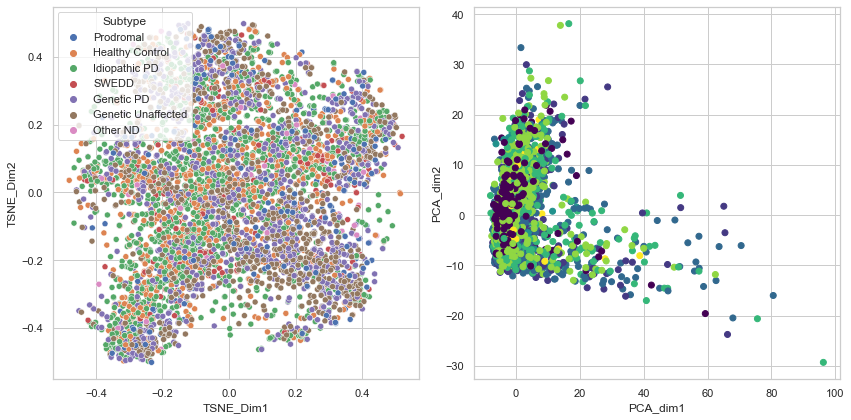

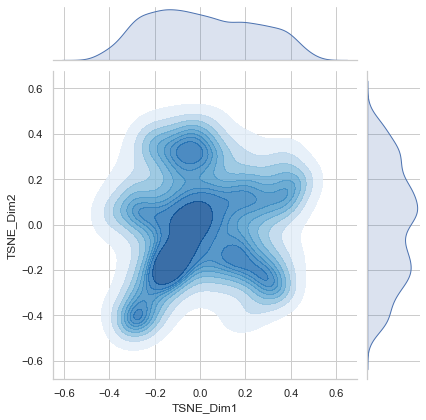

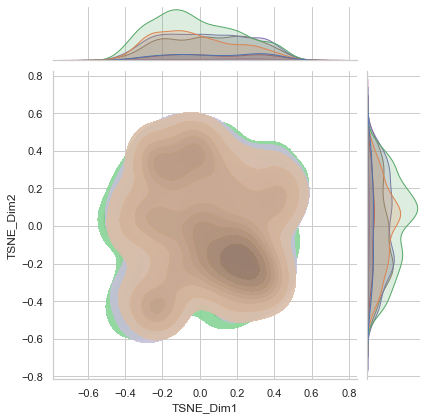

In [23]:
TSNE_params = {
            "early_exaggeration" : 50,
            "learning_rate" : 500, 
            #"perplexity" : 75, 
            "perplexity" : 100, 
            "min_grad_norm" : 1e-7, 
            "n_iter" : 2000,
            "n_components" : 2
        }
visualisation.plot_clusters(compressed_dataframe, label, TSNE_params)

In [24]:
# filtering data
# Convert clinical_info and filenames to Series for easy filtering
clinical_info_series = pd.Series(label)
filenames_series = pd.Series(filenames)

# Create boolean masks for filtering
filenames_mask = filenames_series.str.contains("BL")

# Apply the  mask to your dataset
filtered_dat = compressed_dataframe[filenames_mask]
filtered_clinical_info = clinical_info_series[filenames_mask]

# Check the shape of the filtered dataset
print(filtered_dat.shape)
print(filtered_clinical_info.shape)

(1521, 32)
(1521,)


/opt/homebrew/anaconda3/envs/thesis/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/Users/aygalic/Thesis/genome_analysis_parkinson/thesis_related/../src/utils/visualisation.py:197: UserWarning:

No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored



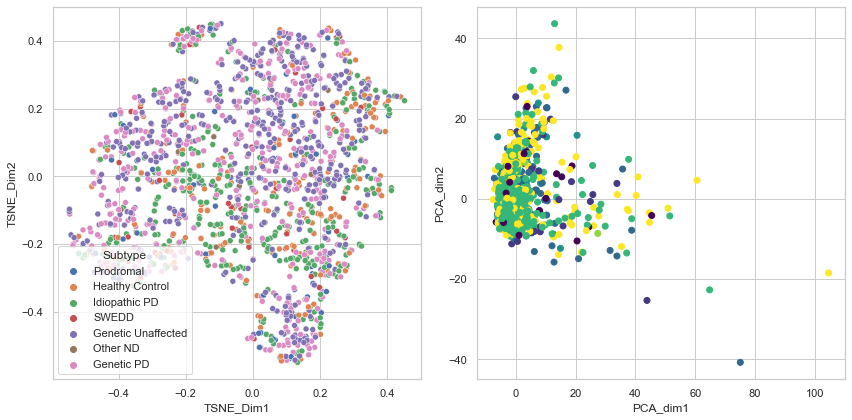

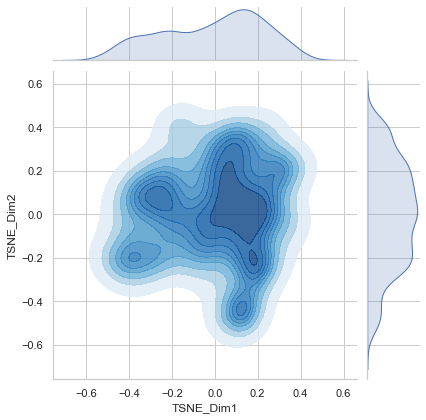

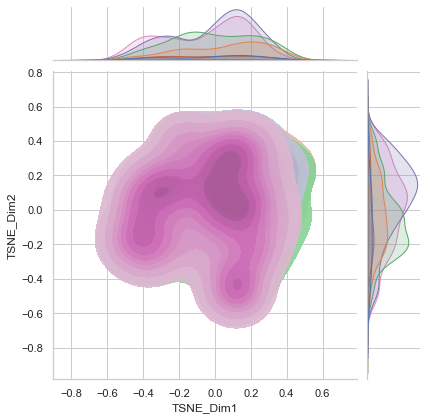

In [29]:
TSNE_params = {
            "early_exaggeration" : 5,
            "learning_rate" : 500, 
            "perplexity" : 20, 
            "min_grad_norm" : 1e-7, 
            "n_iter" : 1000,
            "n_components" : 2
        }
visualisation.plot_clusters(filtered_dat, filtered_clinical_info, TSNE_params)

In [30]:
# filtering data
# Convert clinical_info and filenames to Series for easy filtering
clinical_info_series = pd.Series(label)
filenames_series = pd.Series(filenames)

# Create boolean masks for filtering
#clinical_mask = clinical_info_series == "Genetic PD"
clinical_mask = clinical_info_series == "Idiopathic PD"
filenames_mask = filenames_series.str.contains("BL")

# Combine the masks using logical AND
combined_mask = filenames_mask & clinical_mask

# Apply the combined mask to your dataset

filtered_dat = compressed_dataframe[combined_mask]
filtered_clinical_info = clinical_info_series[combined_mask]
filtered_filenames_series = filenames_series[combined_mask] # just to check

# Check the shape of the filtered dataset
print(filtered_dat.shape)
print(filtered_clinical_info.shape)

(343, 32)
(343,)


/opt/homebrew/anaconda3/envs/thesis/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/Users/aygalic/Thesis/genome_analysis_parkinson/thesis_related/../src/utils/visualisation.py:197: UserWarning:

No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored



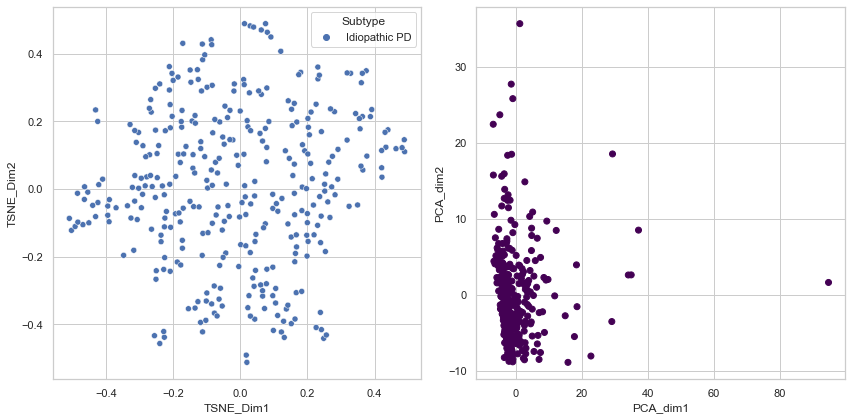

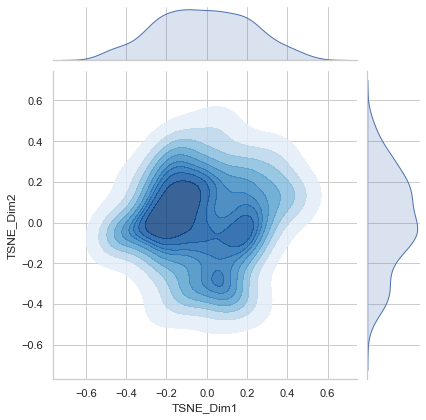

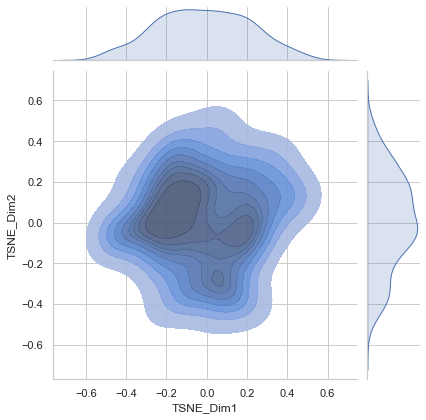

In [39]:
params = {"early_exaggeration":10,
              "learning_rate":700, 
              "perplexity":15, 
              "min_grad_norm":1e-7, 
              "n_iter":1000,
              "n_components":2}
visualisation.plot_clusters(filtered_dat, filtered_clinical_info, params)

In [40]:
# filtering data
# Convert clinical_info and filenames to Series for easy filtering
clinical_info_series = pd.Series(label)
filenames_series = pd.Series(filenames)

# Create boolean masks for filtering
#clinical_mask = clinical_info_series == "Genetic PD"
clinical_mask = clinical_info_series == "Idiopathic PD"

# Combine the masks using logical AND
combined_mask = clinical_mask

# Apply the combined mask to your dataset

filtered_dat = compressed_dataframe[combined_mask]
filtered_clinical_info = clinical_info_series[combined_mask]
filtered_filenames_series = filenames_series[combined_mask] # just to check

# Check the shape of the filtered dataset
print(filtered_dat.shape)
print(filtered_clinical_info.shape)

(1400, 32)
(1400,)


/opt/homebrew/anaconda3/envs/thesis/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/Users/aygalic/Thesis/genome_analysis_parkinson/thesis_related/../src/utils/visualisation.py:197: UserWarning:

No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored



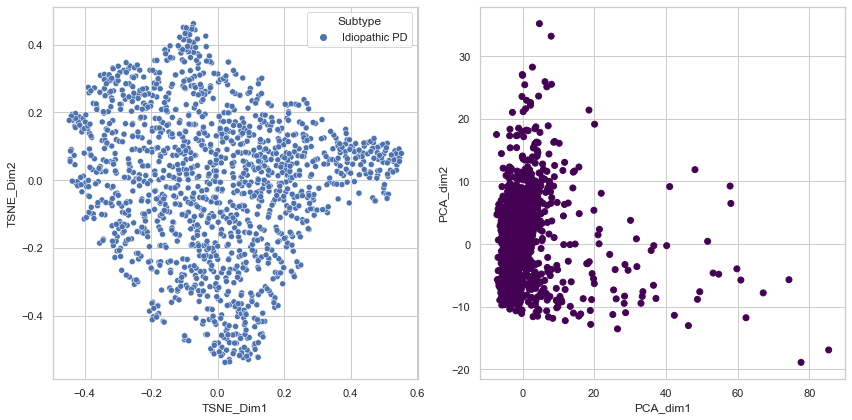

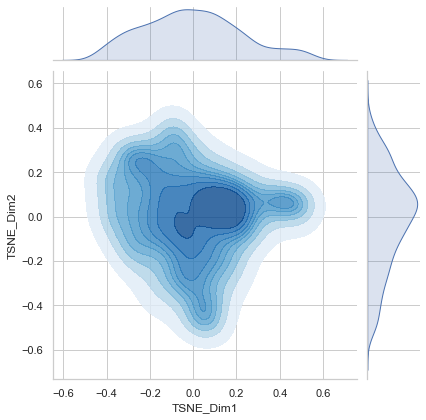

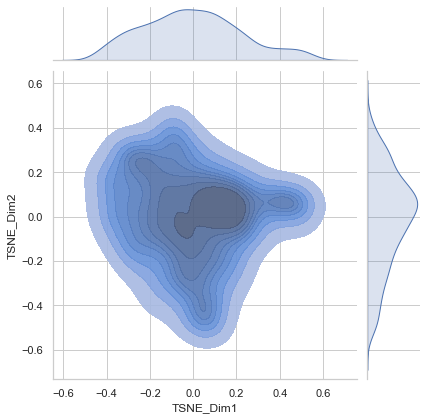

In [42]:
params = {"early_exaggeration":5,
              "learning_rate":100, 
              "perplexity":30, 
              "min_grad_norm":1e-7, 
              "n_iter":5000,
              "n_components":2}
visualisation.plot_clusters(filtered_dat, filtered_clinical_info, params)

## If we are happy with the visualisation we can proceed to save the encoded dataset

In [40]:
#df.to_csv("../workfiles/FC_ae_"+x_train._name+".csv", index=False)
